Attention: ce notebook nécessite un OS Linux.<br>
Mise en oeuvre rapide sous Windows: wsl (avec environnement spécifique) généré via <br>
<code> jupyter notebook --no-browser --port=8888 </code> <br>
La session MLFLOW doit également être exécutée sous environnement WSL

In [1]:
import pandas as pd
import autosklearn.classification
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import re

In [2]:
# Asignation du serveur de tracking MLFlow
mlflow.set_tracking_uri("http://localhost:5000")
# Création de l'expérimentation "approche classique"
mlflow.set_experiment("approche_classique")

<Experiment: artifact_location='mlflow-artifacts:/374735653194037029', creation_time=1729108772155, experiment_id='374735653194037029', last_update_time=1729108772155, lifecycle_stage='active', name='approche_classique', tags={}>

In [3]:
# Chargement des données
train_df = pd.read_csv('./data/train_df.csv')
val_df = pd.read_csv('./data/val_df.csv')
test_df = pd.read_csv('./data/test_df.csv')

In [4]:
# Séparation des features (X) et des labels (y)
X_train, y_train = train_df['preprocessed_text'], train_df['target']
X_val, y_val = val_df['preprocessed_text'], val_df['target']
X_test, y_test = test_df['preprocessed_text'], test_df['target']

# Concatenation de train et val pour utiliser avec Auto-sklearn (val sera utilisé plus tard)
X_train_combined = pd.concat([X_train, X_val])
y_train_combined = pd.concat([y_train, y_val])

In [5]:
# Création du pipeline avec vectorisation
pipeline = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 2))  # Utilisation de bigrams pour simuler un contexte plus large
)

In [6]:
# Transformation des données
X_train_combined_preprocessed = pipeline.fit_transform(X_train_combined)
X_test_preprocessed = pipeline.transform(X_test)

In [7]:
# Auto-sklearn - Configuration de l'analyse de sentiment
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=3600,  # Temps total en secondes
    per_run_time_limit=300,        # Limite de temps par essai
    metric=autosklearn.metrics.accuracy,
)

Accuracy: 0.7047560222359481
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.73      0.71       808
           1       0.72      0.68      0.70       811

    accuracy                           0.70      1619
   macro avg       0.71      0.70      0.70      1619
weighted avg       0.71      0.70      0.70      1619



2024/11/04 00:09:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


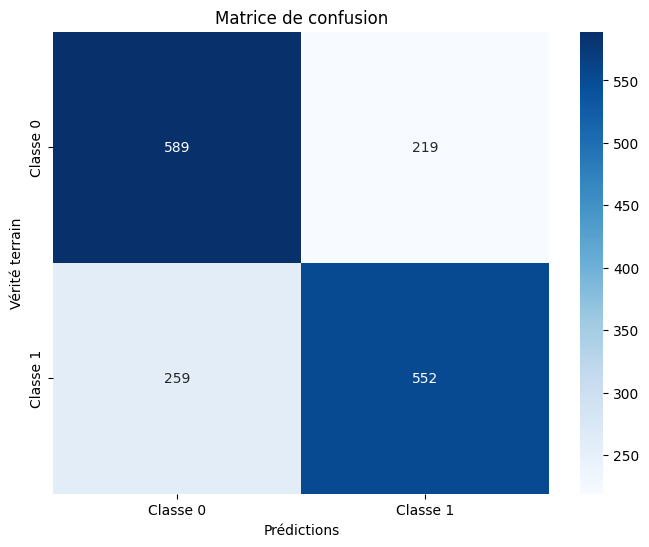

/tmp/ipykernel_1210/3107374885.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_info_df = model_info_df.append({'Model': str(model), 'Weight': weight, 'Params': params}, ignore_index=True)
/tmp/ipykernel_1210/3107374885.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_info_df = model_info_df.append({'Model': str(model), 'Weight': weight, 'Params': params}, ignore_index=True)
/tmp/ipykernel_1210/3107374885.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  model_info_df = model_info_df.append({'Model': str(model), 'Weight': weight, 'Params': params}, ignore_index=True)
/tmp/ipykernel_1210/3107374885.py:52: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future v

In [8]:
import mlflow
import mlflow.sklearn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Logger avec MLflow
with mlflow.start_run(run_name="AutoSKLearn"):
    # Entraînement du modèle Auto-sklearn
    automl.fit(X_train_combined_preprocessed, y_train_combined)

    # Prédiction sur les données de test
    y_pred = automl.predict(X_test_preprocessed)

    # Calcul de l'exactitude
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # Rapport de classification détaillé
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)

    # Logging des paramètres et métriques du modèle principal
    mlflow.log_param("time_left_for_this_task", 3600)
    mlflow.log_param("per_run_time_limit", 300)
    mlflow.log_metric("accuracy", accuracy)

    # Logging du modèle principal dans MLflow
    mlflow.sklearn.log_model(automl, "best_model")

    # Création de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)

    # Affichage de la matrice de confusion avec Seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
    plt.xlabel("Prédictions")
    plt.ylabel("Vérité terrain")
    plt.title("Matrice de confusion")
    plt.show()

    # Enregistrer tous les modèles testés et leurs hyperparamètres
    models_with_weights = automl.get_models_with_weights()
    
    # Créer un DataFrame pour stocker les informations des modèles
    model_info_df = pd.DataFrame(columns=['Model', 'Weight', 'Params'])

    for weight, model in models_with_weights:
        # Obtenir les hyperparamètres du modèle
        params = model.get_params()
        model_info_df = model_info_df.append({'Model': str(model), 'Weight': weight, 'Params': params}, ignore_index=True)

    # Enregistrer le DataFrame dans MLflow en tant que artefact
    model_info_df.to_csv('models_info.csv', index=False)
    mlflow.log_artifact('models_info.csv')

    # Logging du rapport de classification dans MLflow sous forme de texte
    mlflow.log_text(report, "classification_report.txt")


In [12]:
# Afficher les modèles explorés et le meilleur modèle
print(automl.show_models())

{2: {'model_id': 2, 'rank': 1, 'cost': 0.2896379525593009, 'ensemble_weight': 0.02, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7fa264b982b0>, 'balancing': Balancing(random_state=1), 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7fa263a49f70>, 'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7fa263a49dc0>, 'sklearn_classifier': RandomForestClassifier(max_features=165, n_estimators=512, n_jobs=1,
                       random_state=1, warm_start=True)}, 4: {'model_id': 4, 'rank': 2, 'cost': 0.32459425717852686, 'ensemble_weight': 0.02, 'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7fa264b982e0>, 'balancing': Balancing(random_state=1, strategy='weighting'), 'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocesso

In [13]:
best_model = automl.get_models_with_weights()[0][1]
print(best_model)

SimpleClassificationPipeline({'balancing:strategy': 'none', 'classifier:__choice__': 'passive_aggressive', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'no_preprocessing', 'classifier:passive_aggressive:C': 0.14268277711454813, 'classifier:passive_aggressive:average': 'False', 'classifier:passive_aggressive:fit_intercept': 'True', 'classifier:passive_aggressive:loss': 'hinge', 'classifier:passive_aggressive:tol': 0.0002600768160857831, 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'none'},
dataset_properties={
  'task': 1,
  'sparse': True,
  'multilabel': False,
  'multiclass': False,
  'target_type': 'classification',
  'signed': False})
